In [5]:
import pandas as pd
import numpy as np
import argparse
import time
import math
import copy

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdmolops
from rdkit.Chem import Crippen
from rdkit.Chem import PandasTools
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.rdchem import GetPeriodicTable
from rdkit import DataStructs
from rdkit.Chem import Descriptors
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.ML.Descriptors import MoleculeDescriptors

from mordred import Calculator, descriptors
from padelpy import padeldescriptor, from_smiles

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
#from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import metrics
from sklearn.svm import SVR

import xgboost as xgb

import torch
from torch_geometric.data import Data
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Linear, Sequential, BatchNorm1d #, ReLU
from torch.nn.functional import relu
from torch.utils.data.sampler import SubsetRandomSampler


# Read Data

In [6]:
full_train_mordred_summation = pd.read_csv('../step3-train_test_split/xG_baruta_train_mordred_summation.csv')
test_mordred_summation = pd.read_csv('../step3-train_test_split/xG_baruta_test_mordred_summation.csv')

full_Z_train = pd.read_csv('../step3-train_test_split/train_property.csv')
Z_test = pd.read_csv('../step3-train_test_split/test_property.csv')

In [7]:
#Mordred
full_train_mordred_summation=np.array(full_train_mordred_summation)
test_mordred_summation=np.array(test_mordred_summation)

In [8]:
train_mordred_summation, valida_mordred_summation, Z_train, Z_valida = train_test_split(full_train_mordred_summation, full_Z_train, test_size=0.1, random_state=142)

In [9]:
df_Z_train = Z_train
df_Z_valida = Z_valida
df_Z_test = Z_test

Z_train = np.array(Z_train) 
Z_valida = np.array(Z_valida) 
Z_test = np.array(Z_test)

Z_train = Z_train.ravel()
Z_valida = Z_valida.ravel()
Z_test = Z_test.ravel()

In [10]:
Z_train.shape, Z_valida.shape, Z_test.shape

((759,), (85,), (135,))

# Define the ANN model using PyTorch.

In [11]:
# Define the ANN model using PyTorch.

class ANNModel_mordred(nn.Module):
    def __init__(self, input_dim, hidden_layers):
        super(ANNModel_mordred, self).__init__()
        self.layers = nn.ModuleList()
        
        # Input layer to first hidden layer
        self.layers.append(nn.Linear(input_dim, hidden_layers[0]))
        self.layers.append(nn.ReLU())
        
        # Adding subsequent hidden layers
        for i in range(1, len(hidden_layers)):
            self.layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
            self.layers.append(nn.ReLU())
        
        # Last hidden layer to output layer
        self.layers.append(nn.Linear(hidden_layers[-1], 1))
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


# Make Predictions Using Neural Network

In [12]:
train_nn_mordred_summation = torch.tensor(train_mordred_summation, dtype=torch.float32)
Z_train_nn = torch.tensor(Z_train, dtype=torch.float32).view(-1, 1)

valida_nn_mordred_summation = torch.tensor(valida_mordred_summation, dtype=torch.float32)
Z_valida_nn = torch.tensor(Z_valida, dtype=torch.float32).view(-1, 1)

test_nn_mordred_summation = torch.tensor(test_mordred_summation, dtype=torch.float32)
Z_test_nn = torch.tensor(Z_test, dtype=torch.float32).view(-1, 1)

In [13]:
# Create the dataset and dataloader
train_dataset_mordred_summation = TensorDataset(train_nn_mordred_summation, Z_train_nn)
train_loader_mordred_summation = DataLoader(train_dataset_mordred_summation, batch_size=32, shuffle=False)

valida_dataset_mordred_summation = TensorDataset(valida_nn_mordred_summation, Z_valida_nn)
valida_loader_mordred_summation = DataLoader(valida_dataset_mordred_summation, batch_size=32, shuffle=False)

test_dataset_mordred_summation = TensorDataset(test_nn_mordred_summation, Z_test_nn)
test_loader_mordred_summation = DataLoader(test_dataset_mordred_summation, batch_size=32, shuffle=False)

In [14]:
# Parameters

input_dim_mordred_summation = train_nn_mordred_summation.shape[1]
hidden_layers_mordred_summation = [512, 512, 256, 128, 64] #, 64, 32]
num_epochs_mordred_summation = 300
batch_size_mordred_summation = 32
learning_rate_mordred_summation = 0.00005
#train_nn_rdkit is a DataFrame or NumPy array with shape (num_samples, num_features)

In [15]:
# Create an instance of the ANN model
model_mordred_summation = ANNModel_mordred(input_dim_mordred_summation,hidden_layers_mordred_summation)

#Define the Loss Function and Optimizer:
criterion = nn.MSELoss()  # Mean Squared Error for regression tasks
optimizer = optim.Adam(model_mordred_summation.parameters(), lr=learning_rate_mordred_summation)

In [16]:
# Train the Model:
mordred_summation_training_loss=[]
mordred_summation_validation_loss=[]

for epoch in range(num_epochs_mordred_summation):
    model_mordred_summation.train()
    for X_batch, y_batch in train_loader_mordred_summation:
        # Forward pass
        outputs = model_mordred_summation(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
    for X_val_batch, y_val_batch in valida_loader_mordred_summation:
        # Forward pass
        outputs = model_mordred_summation(X_val_batch)
        val_loss = criterion(outputs, y_val_batch)

    # Print loss for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs_mordred_summation}], train_Loss: {loss.item():.4f}, valida_Loss: {val_loss.item():.4f}')
    # Append the losses
    mordred_summation_training_loss.append(loss.item())
    mordred_summation_validation_loss.append(val_loss.item())

Epoch [1/300], train_Loss: 11.2647, valida_Loss: 10.8535
Epoch [2/300], train_Loss: 10.7698, valida_Loss: 10.3092
Epoch [3/300], train_Loss: 9.0671, valida_Loss: 8.4016
Epoch [4/300], train_Loss: 4.4050, valida_Loss: 3.1790
Epoch [5/300], train_Loss: 2.9042, valida_Loss: 1.4071
Epoch [6/300], train_Loss: 2.5089, valida_Loss: 1.3234
Epoch [7/300], train_Loss: 2.2912, valida_Loss: 1.2317
Epoch [8/300], train_Loss: 2.0746, valida_Loss: 1.1711
Epoch [9/300], train_Loss: 1.8668, valida_Loss: 1.1067
Epoch [10/300], train_Loss: 1.6627, valida_Loss: 1.0389
Epoch [11/300], train_Loss: 1.4628, valida_Loss: 0.9672
Epoch [12/300], train_Loss: 1.2754, valida_Loss: 0.8931
Epoch [13/300], train_Loss: 1.1068, valida_Loss: 0.8168
Epoch [14/300], train_Loss: 0.9628, valida_Loss: 0.7430
Epoch [15/300], train_Loss: 0.8493, valida_Loss: 0.6761
Epoch [16/300], train_Loss: 0.7688, valida_Loss: 0.6202
Epoch [17/300], train_Loss: 0.7153, valida_Loss: 0.5767
Epoch [18/300], train_Loss: 0.6788, valida_Loss: 0.54

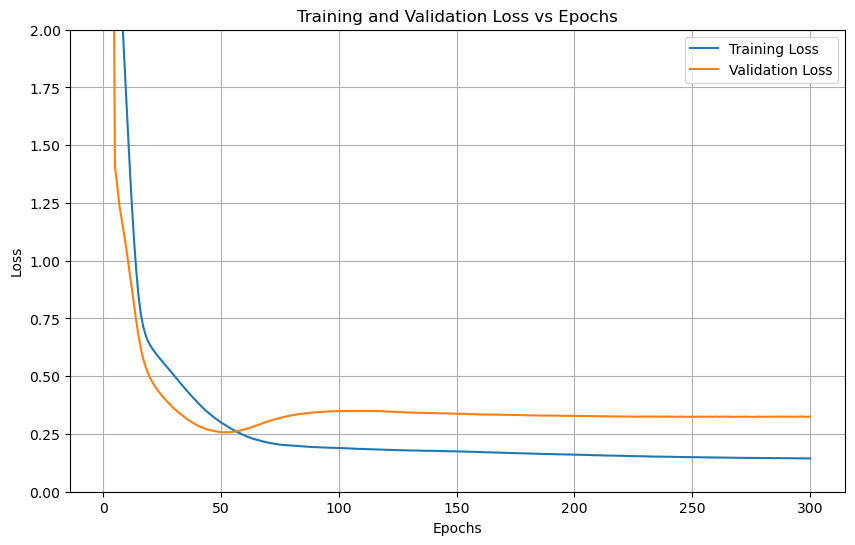

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs_mordred_summation + 1), mordred_summation_training_loss, label='Training Loss')
plt.plot(range(1, num_epochs_mordred_summation + 1), mordred_summation_validation_loss, label='Validation Loss')
#plt.xlim([0, 7])
plt.ylim([0, 2.0])
# Adding titles and labels
plt.title('Training and Validation Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Print performance parameters

In [21]:
# Evaluate the Model:

model_mordred_summation.eval()
with torch.no_grad():
    Z_pred_train_mordred_summation = model_mordred_summation(train_nn_mordred_summation)
    train_loss_mordred_summation = criterion(Z_pred_train_mordred_summation, Z_train_nn).item()
    r2_train_mordred_summation = r2_score(Z_train_nn.cpu(), Z_pred_train_mordred_summation.cpu())

    Z_pred_valida_mordred_summation = model_mordred_summation(valida_nn_mordred_summation)
    valida_loss_mordred_summation = criterion(Z_pred_valida_mordred_summation, Z_valida_nn).item()
    r2_valida_mordred_summation = r2_score(Z_valida_nn.cpu(), Z_pred_valida_mordred_summation.cpu())

    Z_pred_test_mordred_summation = model_mordred_summation(test_nn_mordred_summation)
    test_loss_mordred_summation = criterion(Z_pred_test_mordred_summation, Z_test_nn).item()
    r2_test_mordred_summation = r2_score(Z_test_nn.cpu(), Z_pred_test_mordred_summation.cpu())

print(f'Training Loss (MSE): {train_loss_mordred_summation:.4f}')
print(f'Validation Loss (MSE): {valida_loss_mordred_summation:.4f}')
print(f'Test Loss (MSE): {test_loss_mordred_summation:.4f}')

print(f'Training R²: {r2_train_mordred_summation:.4f}')
print(f'Validation R²: {r2_valida_mordred_summation:.4f}')
print(f'Test R²: {r2_test_mordred_summation:.4f}')

Training Loss (MSE): 0.0604
Validation Loss (MSE): 0.2221
Test Loss (MSE): 0.2351
Training R²: 0.9593
Validation R²: 0.8193
Test R²: 0.8969


## Show Parity Plot

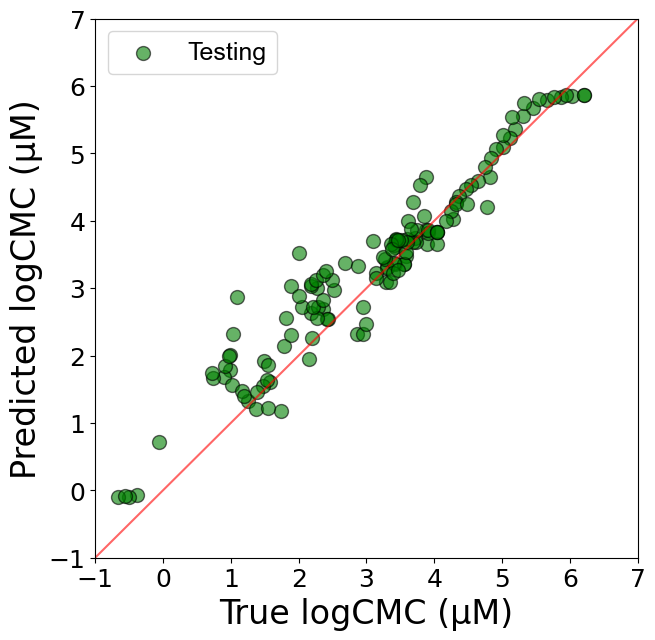

In [22]:
label_fs = 24
legend_label_fs = 18
ticks_fs = 18
marker_s = 100
ap = 0.6

plt.rcParams["figure.figsize"] = (7, 7)
legend_font_properties = {'family': 'arial','size': legend_label_fs}#,'weight': 'bold'}
plt.scatter(Z_test_nn.numpy(), Z_pred_test_mordred_summation.numpy(),s=marker_s, alpha=ap, color='green', edgecolor='black',label="Testing") 
plt.plot([-1,7], [-1,7], alpha=ap, color='red')
plt.xlim([-1, 7])
plt.ylim([-1, 7])
plt.xlabel('True logCMC (\u03bcM)', fontsize=label_fs)
plt.ylabel('Predicted logCMC (\u03bcM)', fontsize=label_fs)
plt.xticks(fontsize=ticks_fs)
plt.yticks(fontsize=ticks_fs)
# Adding legend
plt.legend(prop=legend_font_properties)
plt.show()


# Distinguish points on parity plot based on charges

In [23]:
import pandas as pd
import numpy as np

# Load data

total_smiles = pd.read_csv('../dataset/total_smile.csv')
train_smiles = pd.read_csv('../step3-train_test_split/train_smile.csv')
test_smiles = pd.read_csv('../step3-train_test_split/test_smile.csv')
train_property = pd.read_csv('../step3-train_test_split/train_property.csv')
test_property = pd.read_csv('../step3-train_test_split/test_property.csv')

# Convert prediction arrays
Predicted_test_value = Z_pred_test_mordred_summation.numpy().flatten()
predicted_train_value = Z_pred_train_mordred_summation.numpy().flatten()
predicted_valida_value = Z_pred_valida_mordred_summation.numpy().flatten()

# Step 1: Use index-preserved dataframes to reconstruct train_df and test_df
# -- Combine training and validation sets
train_df = train_smiles.loc[df_Z_train.index].copy()
valida_df = train_smiles.loc[df_Z_valida.index].copy()

train_df['true_log_CMC'] = df_Z_train.values
valida_df['true_log_CMC'] = df_Z_valida.values

train_df['category'] = 'train'
valida_df['category'] = 'train'

train_df['predicted_log_CMC'] = predicted_train_value
valida_df['predicted_log_CMC'] = predicted_valida_value

# Concatenate train + validation
combined_train_df = pd.concat([train_df, valida_df], ignore_index=True)


# Step 2: Construct test_df
test_df = test_smiles.copy()
test_df['true_log_CMC'] = df_Z_test.values
test_df['category'] = 'test'
test_df['predicted_log_CMC'] = Predicted_test_value

# Step 3: Combine all
combined_test_train_df = pd.concat([combined_train_df, test_df], ignore_index=True)



# Step 1: Identify duplicated keys
key_cols = ['smile_A', 'mol_fraction_A', 'smile_B', 'mol_fraction_B']
duplicated_keys = combined_test_train_df.duplicated(subset=key_cols, keep=False)

# Step 2: Remove all duplicated entries (i.e., keep only unique ones)
clean_combined_df = combined_test_train_df[~duplicated_keys].copy()

# Step 3: Merge with total_smiles
merged_df = total_smiles.merge(
    clean_combined_df,
    on=key_cols,
    how='left'
)


In [24]:
merged_df

,smile_A,mol_fraction_A,smile_B,mol_fraction_B,true_log_CMC,category,predicted_log_CMC
0,CCCCCCCCCCCCOS(=O)(=O)[O-],0.0,CCCCCCCCCCCCCCCC[N+](C)(C)C,1.0,2.857332,test,2.327840
1,CCCCCCCCCCCCOS(=O)(=O)[O-],0.1,CCCCCCCCCCCCCCCC[N+](C)(C)C,0.9,0.991226,test,2.010393
2,CCCCCCCCCCCCOS(=O)(=O)[O-],0.2,CCCCCCCCCCCCCCCC[N+](C)(C)C,0.8,0.991226,test,1.784500
3,CCCCCCCCCCCCOS(=O)(=O)[O-],0.3,CCCCCCCCCCCCCCCC[N+](C)(C)C,0.7,0.903090,test,1.687579
4,CCCCCCCCCCCCOS(=O)(=O)[O-],0.4,CCCCCCCCCCCCCCCC[N+](C)(C)C,0.6,0.732394,test,1.670505
...,...,...,...,...,...,...,...
974,CCCCCCCCCCCCCCOCC(O)Cn1cc[n+](CCC[n+]2ccn(CC(O...,0.5,CCCCCCCCCCCCCCOCC(O)Cn1cc[n+](CCC[n+]2ccn(CC(O...,0.5,1.851000,train,1.560441
975,CCCCCCCCCCCCCCC(CSCCSCC(CCCCCCCCCCCCCC)[n+]1cc...,0.5,CCCCCCCCCCCCCCC(CSCCSCC(CCCCCCCCCCCCCC)[n+]1cc...,0.5,1.342000,train,1.463064
976,CCCCCCCCCCCCCCC(CSCCCSCC(CCCCCCCCCCCCCC)[n+]1c...,0.5,CCCCCCCCCCCCCCC(CSCCCSCC(CCCCCCCCCCCCCC)[n+]1c...,0.5,1.322000,train,1.419737
977,CCCCCCCCCCCCCCC(CSCCCCSCC(CCCCCCCCCCCCCC)[n+]1...,0.5,CCCCCCCCCCCCCCC(CSCCCCSCC(CCCCCCCCCCCCCC)[n+]1...,0.5,1.301000,train,1.371290


In [25]:
from rdkit import Chem

def get_formal_charge(smile):
    try:
        mol = Chem.MolFromSmiles(smile)
        if mol is None:
            print(f"Warning: Could not parse SMILES: {smile}")
            return np.nan
        return sum(atom.GetFormalCharge() for atom in mol.GetAtoms())
    except Exception as e:
        print(f"Error parsing SMILES {smile}: {e}")
        return np.nan

merged_df['charge_a'] = merged_df['smile_A'].apply(get_formal_charge)
merged_df['charge_b'] = merged_df['smile_B'].apply(get_formal_charge)


In [26]:
def assign_category(row):
    a = int(round(row['charge_a']))
    b = int(round(row['charge_b']))
    if pd.isna(a) or pd.isna(b):
        return 'unknown'
    if a > 0 and b > 0:
        return 'Cationic - Cationic'
    elif (a > 0 and b == 0) or (a == 0 and b > 0):
        return 'Cationic - Nonionic'
    elif (a > 0 and b < 0) or (a < 0 and b > 0):
        return 'Cationic - Anionic'
    elif a == 0 and b == 0:
        return 'Nonionic - Nonionic'
    elif (a == 0 and b < 0) or (a < 0 and b == 0):
        return 'Anionic - Nonionic'
    elif a < 0 and b < 0:
        return 'Anionic - Anionic'
    else:
        return 'other'


merged_df['charge_category'] = merged_df.apply(assign_category, axis=1)


In [27]:
# merged_df.to_csv('combined_prediction_results.csv', index=False)
# merged_df

In [28]:
print(merged_df['charge_category'].value_counts())


charge_category
Cationic - Cationic    250
Nonionic - Nonionic    225
Cationic - Anionic     145
Anionic - Anionic      145
Anionic - Nonionic     138
Cationic - Nonionic     76
Name: count, dtype: int64


In [29]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# Step 1: Filter test points
categorized_test_df = merged_df[merged_df['category'] == 'test'].copy()


# Step 2: Drop rows with missing values in necessary columns
categorized_test_df = categorized_test_df.dropna(subset=['true_log_CMC', 'predicted_log_CMC', 'charge_category'])




In [30]:
categorized_test_df

,smile_A,mol_fraction_A,smile_B,mol_fraction_B,true_log_CMC,category,predicted_log_CMC,charge_a,charge_b,charge_category
0,CCCCCCCCCCCCOS(=O)(=O)[O-],0.00,CCCCCCCCCCCCCCCC[N+](C)(C)C,1.00,2.857332,test,2.327840,-1,1,Cationic - Anionic
1,CCCCCCCCCCCCOS(=O)(=O)[O-],0.10,CCCCCCCCCCCCCCCC[N+](C)(C)C,0.90,0.991226,test,2.010393,-1,1,Cationic - Anionic
2,CCCCCCCCCCCCOS(=O)(=O)[O-],0.20,CCCCCCCCCCCCCCCC[N+](C)(C)C,0.80,0.991226,test,1.784500,-1,1,Cationic - Anionic
3,CCCCCCCCCCCCOS(=O)(=O)[O-],0.30,CCCCCCCCCCCCCCCC[N+](C)(C)C,0.70,0.903090,test,1.687579,-1,1,Cationic - Anionic
4,CCCCCCCCCCCCOS(=O)(=O)[O-],0.40,CCCCCCCCCCCCCCCC[N+](C)(C)C,0.60,0.732394,test,1.670505,-1,1,Cationic - Anionic
...,...,...,...,...,...,...,...,...,...,...
501,O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...,0.00,CCCCCCCCCCn1cc[n+](C)c1,1.00,4.774517,test,4.202082,0,1,Cationic - Nonionic
502,O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...,0.25,CCCCCCCCCCn1cc[n+](C)c1,0.75,2.361728,test,2.821775,0,1,Cationic - Nonionic
503,O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...,0.50,CCCCCCCCCCn1cc[n+](C)c1,0.50,2.204120,test,2.256974,0,1,Cationic - Nonionic
504,O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...,0.75,CCCCCCCCCCn1cc[n+](C)c1,0.25,2.000000,test,2.884464,0,1,Cationic - Nonionic


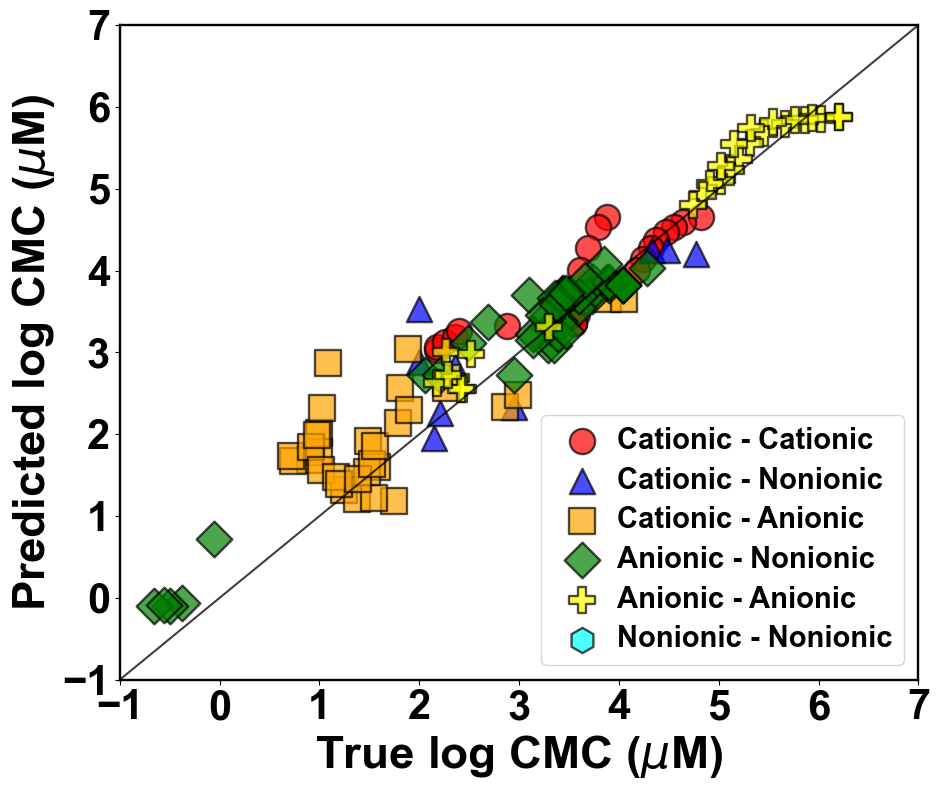

In [31]:
# === Custom legend order ===
desired_order = [
    'Cationic - Cationic',
    'Cationic - Nonionic',
    'Cationic - Anionic',
    'Anionic - Nonionic',
    'Anionic - Anionic',
    'Nonionic - Nonionic'
]

custom_colors = {
    'Cationic - Cationic': 'red',  # Muted Blue (Cool & Distinct)
    'Cationic - Nonionic': 'blue',  # Soft Orange (Warm & Eye-Catching)
    'Cationic - Anionic': 'orange',   # Teal Green (Refreshing & Different)
    'Anionic - Nonionic': 'green',    # Soft Red (Rich & Noticeable)
    'Anionic - Anionic': 'yellow',    # Elegant Purple (Balanced & Subtle)
    'Nonionic - Nonionic': 'cyan',  # Forest Green (Deep & Natural)
}



# Step 3: Define unique categories and color map
unique_categories = categorized_test_df['charge_category'].unique()

# Assign colors manually based on the order
#colors = plt.cm.tab10(np.linspace(0, 1, len(desired_order)))
#color_map = dict(zip(desired_order, colors))

markers = ['o', '^', 's', 'D', 'P', 'h', 'X', 'h', '+', 'x']
marker_map = dict(zip(desired_order, markers))

# Step 4: Plot
plt.figure(figsize=(9.5, 8))

for cat in desired_order:
    subset = categorized_test_df[categorized_test_df['charge_category'] == cat]
    plt.scatter(subset['true_log_CMC'], 
                subset['predicted_log_CMC'],
                label=cat, 
                color=custom_colors[cat], 
                marker=marker_map[cat],
                s=330, 
                edgecolors='k',  # No edge
                linewidths=1.7,
                alpha=0.7)

# Step 5: Add parity line
lims = [-1,7]
plt.plot(lims, lims, '-', alpha=0.75, color='k')

# set x y limits
plt.xlim([-1, 7])
plt.ylim([-1, 7])

# Final plot settings
plt.xlabel("True log CMC ($\mu$M)", fontsize=33, fontname='Arial', fontweight='bold')
plt.ylabel("Predicted log CMC ($\mu$M)", fontsize=33, fontname='Arial', fontweight='bold')

plt.xticks(fontsize=30, fontname='Arial', fontweight='bold')
plt.yticks(fontsize=30, fontname='Arial', fontweight='bold')
#plt.title("Parity Plot of Test Data by Charge Category")
plt.legend(
    loc='lower right',
    #fontsize=12,
    prop={'size': 21, 'weight': 'bold', 'family': 'Arial'},
    labelspacing=0.4,        # vertical space between entries
    handletextpad=0.2        # space between marker and text
)

# Add black border around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.7)

plt.grid(False)
plt.tight_layout()
plt.savefig('final_parity_plot_ANN_Mordred_merging_AM.png', dpi=600, bbox_inches='tight')
plt.show()

# Perform SHAP Analysis

In [32]:
import shap

# SHAP requires a callable function for PyTorch models
def model_forward(x):
    with torch.no_grad():
        return model_mordred_summation(torch.from_numpy(x.astype(np.float32))).numpy()

# Create a SHAP explainer (KernelExplainer works for any model, but slower)
explainer = shap.Explainer(model_forward, train_mordred_summation)

# Compute SHAP values for a few samples
shap_values = explainer(train_mordred_summation)  # Explaining the first 10 samples

C:\Users\achoudh\AppData\Local\miniconda3\envs\CMC_Prediction\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PermutationExplainer explainer: 760it [11:16,  1.12it/s]                                                               


In [33]:
print(shap_values.shape)  # Dimensions of SHAP values
print(train_mordred_summation.shape)  # Dimensions of input features used for explanation

(759, 105)
(759, 105)


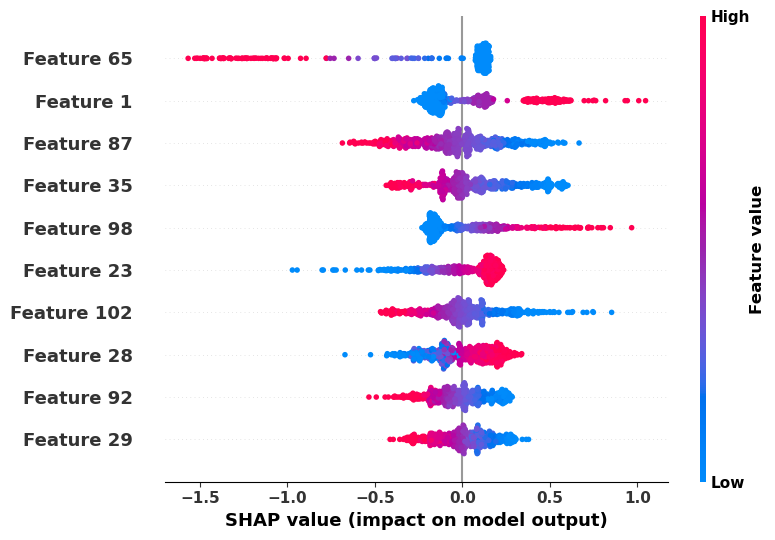

In [34]:
import matplotlib.pyplot as plt
# Visualize the SHAP values
shap.summary_plot(shap_values, train_mordred_summation, max_display=10, show=False)

# Retrieve the current figure and axes objects
fig = plt.gcf()  # Get current figure
ax = plt.gca()   # Get current axis

# Retrieve the current figure and axes objects
fig = plt.gcf()  # Get current figure
ax = plt.gca()   # Get current axis

# Make axis labels and tick labels bold
ax.title.set_fontweight('bold')
ax.xaxis.label.set_fontweight('bold')
ax.yaxis.label.set_fontweight('bold')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontweight('bold')  # Correct way to set bold for x-tick labels
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontweight('bold')  # Correct way to set bold for y-tick labels

# Make feature names bold (custom handling for SHAP plot)
for text in ax.get_yticklabels():
    text.set_fontweight('bold')

# If any text elements are handled outside typical axis labels (specific to SHAP plot)
for text in fig.findobj(plt.Text):
    text.set_fontweight('bold')

#plt.savefig("shap_summary_plot.png", dpi=600, bbox_inches='tight')  # Save with high resolution and tight bounding box
plt.show()

In [35]:
total_descriptors = pd.read_csv('../step1-generating and merging descriptors/total_mordred_descriptors_AM.csv')
xG_boruta_selected_descriptors = pd.read_csv('../step3-train_test_split/xG_baruta_train_mordred_summation.csv')

In [36]:
xG_boruta_selected_descriptors.columns = [total_descriptors.columns[int(col)] for col in xG_boruta_selected_descriptors.columns]

In [37]:
xG_boruta_selected_descriptors.columns

Index(['nAcid', 'nBase', 'VR1_A', 'VR2_A', 'VR3_A', 'nN', 'ATS5i', 'AATS1i',
       'ATSC7c', 'ATSC3d',
       ...
       'MID_C', 'AMID_C', 'MID_N', 'AMID_N', 'AMID_O', 'n5ARing', 'n5AHRing',
       'SLogP', 'GGI4', 'WPath'],
      dtype='object', length=105)

In [38]:
# Update the feature names in shap_values for plotting
shap_values.feature_names = xG_boruta_selected_descriptors.columns.tolist()

In [39]:
print("Shape of shap_values:", shap_values.shape)
print("Number of features in X:", xG_boruta_selected_descriptors.shape[1])

Shape of shap_values: (759, 105)
Number of features in X: 105


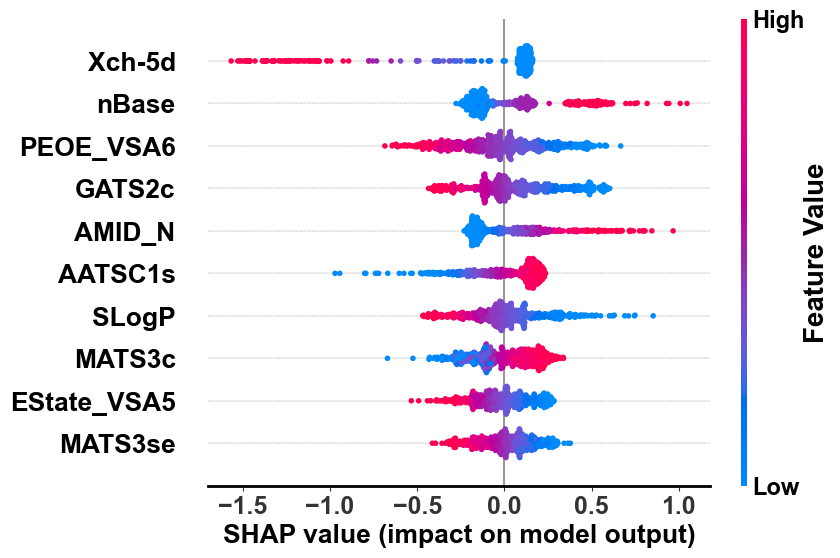

In [40]:
import matplotlib.pyplot as plt
import shap
import matplotlib

# Set global font to Arial
matplotlib.rcParams['font.family'] = 'Arial'

# Create the SHAP summary plot
shap.summary_plot(
    shap_values,
    train_mordred_summation,
    max_display=10,
    show=False,
    color=plt.get_cmap('plasma')
)

fig = plt.gcf()

# 1. Main axis styling
main_ax = fig.axes[0]
main_ax.title.set_fontweight('bold')
main_ax.xaxis.label.set_fontweight('bold')
main_ax.xaxis.label.set_fontsize(19)
main_ax.yaxis.label.set_fontweight('bold')
main_ax.yaxis.label.set_color('black')  # ← Set y-label color to black

# Increase font size of x-axis ticks
for tick in main_ax.xaxis.get_major_ticks():
    tick.label1.set_fontweight('bold')
    tick.label1.set_fontsize(18)  # ← Increase x-axis tick font size

# Make y-axis tick labels bold
for tick in main_ax.yaxis.get_major_ticks():
    tick.label1.set_fontweight('bold')
    tick.label1.set_fontsize(19)
    tick.label1.set_color('black')

# Make feature names bold
for text in main_ax.get_yticklabels():
    text.set_fontweight('bold')

# Add black border around plot
for spine in main_ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)

# 2. Modify "low" and "high" text in colorbar
for text in fig.findobj(plt.Text):
    if text.get_text().strip().lower() in ["low", "high"]:
        text.set_fontsize(17)
        text.set_fontweight("bold")
        text.set_fontname("Arial")

# 3. Modify colorbar ylabel "feature value"
for ax in fig.axes:
    if ax.get_ylabel().strip().lower() == "feature value":
        ax.set_ylabel("Feature Value", fontsize=20, fontweight='bold', fontname='Arial')


plt.grid(axis='y', color='black', linestyle='dotted', linewidth=0.25)
# Save and show
plt.savefig("shap_summary_plot.png", dpi=600, bbox_inches='tight', transparent=True)
plt.show()
